# Perceptual Control A - Process Data

Note: this includes the logic for updating the database for excluded participants

In [1]:
import urllib.request
from functools import lru_cache
import datetime
import csv, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from msdm.domains import GridWorld
from msdm.algorithms import PolicyIteration
from vgc_project import gridutils, sampsat

In [2]:
# load experiment parameters
expConfig = json.load(open("config.json", 'r'))
EXPERIMENT_CODE_VERSION = expConfig['params']['EXPERIMENT_CODE_VERSION']
cond1 = expConfig['timelines'][0]
basegrids = json.load(open("../mazes/mazes_0-11.json", "r"))

CREDENTIALS = json.load(open("../credentials.json", 'r'))
EXPURL = CREDENTIALS["EXPURL"]
USERNAME = CREDENTIALS["USERNAME"]
PASSWORD = CREDENTIALS["PASSWORD"]
print("Credentials:")
print(CREDENTIALS)

DESTDIR = "./data/"
if not os.path.exists(DESTDIR):
    os.mkdir(DESTDIR)
sourcedest = [
    (f"data/{EXPERIMENT_CODE_VERSION}/trialdata", DESTDIR+"rawtrialdata.csv"),
    (f"data/{EXPERIMENT_CODE_VERSION}/questiondata", DESTDIR+"rawquestiondata.csv"),
    (f"data/{EXPERIMENT_CODE_VERSION}/bonusdata", DESTDIR+"rawbonusdata.csv"),
    (f"data/{EXPERIMENT_CODE_VERSION}/conditiondata", DESTDIR+"rawconditiondata.csv")
]

password_mgr = urllib.request.HTTPPasswordMgrWithDefaultRealm()
password_mgr.add_password(None, EXPURL, USERNAME, PASSWORD)
handler = urllib.request.HTTPBasicAuthHandler(password_mgr)

In [3]:
for SOURCE, DEST in sourcedest:
    opener = urllib.request.build_opener(handler)
    opener.open(EXPURL+SOURCE)
    urllib.request.install_opener(opener)
    urllib.request.urlretrieve(EXPURL+SOURCE, DEST)   

In [4]:
csv.field_size_limit(sys.maxsize)
trialdata = [line for line in csv.reader(open(sourcedest[0][1], 'r'))]
questiondata = [line for line in csv.reader(open(sourcedest[1][1], 'r'))]
bonusdata = [line for line in csv.reader(open(sourcedest[2][1], 'r'))]
conditiondata = [line for line in csv.reader(open(sourcedest[3][1], 'r'))]

In [5]:
psiturk_conditions = pd.DataFrame(conditiondata, columns=['psiturk_id', 'condition'])

In [6]:
trials = []
errors = []
for psiturk_id, idx, datetime_ms, entry in trialdata:
    if "debug" in psiturk_id:
        continue
    datetime_ms = datetime.datetime.fromtimestamp(float(datetime_ms)/1000.)
    idx = int(idx)
    entry = json.loads(entry)
    try:
        assert idx == entry['trial_index']
    except AssertionError as e :
        errors.append((e, psiturk_id, idx, datetime_ms, entry))
    trials.append({
        "psiturk_id": psiturk_id,
        "idx": idx,
        "datetime_ms": datetime_ms,
        "data": entry.get("data", None),
        "trial_type": entry['trial_type'],
        "time_elapsed": entry['time_elapsed'],
        "internal_node_id": float(entry["internal_node_id"].split("-")[1])
    })
trials = pd.DataFrame(trials)
trials = trials[trials.psiturk_id.apply(lambda p: "debug" not in p)]

In [7]:
print(trials.groupby('psiturk_id')['internal_node_id'].max().value_counts())

172.0    167
12.0       8
1.0        4
4.0        3
5.0        3
39.0       1
38.0       1
11.0       1
3.0        1
Name: internal_node_id, dtype: int64


In [8]:
#dot trials
dot_trials = trials[(trials.trial_type == "GridWatchDot")]
dot_trials = dot_trials[(dot_trials.data.apply(lambda d: d['trialparams']['roundtype'] != "practice"))]
dot_trials = pd.concat([
    pd.DataFrame({
        "psiturk_id": dot_trials.psiturk_id,
    }).reset_index(drop=True),
    pd.DataFrame(list(dot_trials.data.apply(lambda d: {**d['trialparams'], **{k: v for k, v in d.items() if k not in ['trialparams', 'taskparams']}}).values))
], axis=1)
dot_trials['dot_duration_ms'] = dot_trials['dotAppearances'].apply(lambda da: da[0]['duration_ms'] if da else float('NaN'))
dot_trials = dot_trials[['original_gridname', 'original_sessionId', 'psiturk_id', 'sessionId', 'TRIAL_DURATION_MS', 'is_yoked', 'hasDot', 'grid', 
                         'transform', 'round', 'dotCatches', 'dotMisfires', 'dot_duration_ms']].reset_index(drop=True)
dot_trials.hasDot = dot_trials.hasDot.fillna(False)
dot_trials['correct'] = dot_trials.apply(lambda r: bool(r['dotCatches']) if r['hasDot'] else (r['dotMisfires'] == 0), axis=1)
dot_trials['bonus'] = dot_trials['correct']*.02
bonusdf = dot_trials[['psiturk_id', 'bonus']]

mean      0.750493
median    0.777778
sem       0.014914
Name: dotCatches, dtype: float64

(0.0, 1.0)

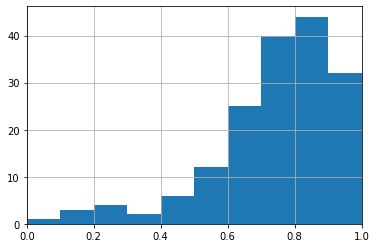

In [9]:
g = dot_trials[dot_trials['hasDot']].groupby("sessionId")['dotCatches'].mean().hist()
display(dot_trials[dot_trials['hasDot']].groupby("sessionId")['dotCatches'].mean().agg(['mean', 'median', 'sem']))
g.set_xlim(0, 1)

mean      0.124119
median    0.000000
sem       0.015943
Name: dotMisfires, dtype: float64

(0.0, 1.0)

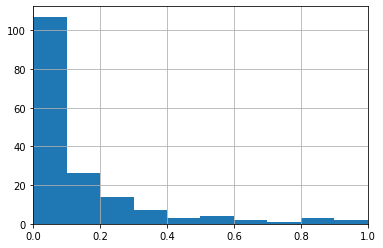

In [10]:
g = dot_trials[~dot_trials['hasDot']].groupby("sessionId")['dotMisfires'].apply(lambda dm: np.mean(dm > 0)).hist()
display(dot_trials[~dot_trials['hasDot']].groupby("sessionId")['dotMisfires'].apply(lambda dm: np.mean(dm > 0)).agg(['mean', 'median', 'sem']))
g.set_xlim(0, 1)

In [11]:
# dot_trials[dot_trials['hasDot']].groupby("sessionId")['dotMisfires'].apply(lambda dm: np.mean(dm > 0))

<AxesSubplot:xlabel='dot_duration_ms', ylabel='correct'>

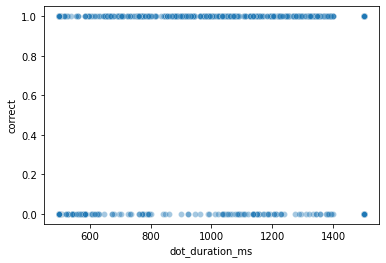

In [12]:
import seaborn as sns
sns.scatterplot(data=dot_trials[dot_trials.hasDot], x='dot_duration_ms', y='correct', alpha=.4)

In [13]:
#awareness trials
attn_trials = trials[(trials.trial_type == "GridBlockAttentionQuery")]
attn_trials = pd.concat([
    pd.DataFrame({
        "psiturk_id": attn_trials.psiturk_id,
    }).reset_index(drop=True),
    pd.DataFrame(list(attn_trials.data.values))
], axis=1)
attn_trials['attn_resp'] = attn_trials['response'].apply(int)
attn_trials['attn_resp_N'] = (attn_trials['attn_resp'] - 1)/(8 - 1)
attn_trials['rt'] = attn_trials['responsetime'] - attn_trials['starttime']
attn_trials['obstacle'] = attn_trials['probeobs']
attn_trials['transform'] = attn_trials.navtrialparams.apply(lambda tp: tp['transform'])
attn_trials['grid'] = attn_trials.navtrialparams.apply(lambda tp: tp['grid'])
attn_trials = attn_trials[['psiturk_id', 'sessionId', 'grid', 'transform', 'round', 'starttime', 'responsetime',
                           'queryround', 'obstacle', 'rt', 'response', 'attn_resp', 'attn_resp_N']].reset_index(drop=True)
round_count = attn_trials.groupby(['psiturk_id', 'sessionId'])['round'].count()
try:
    assert all(round_count == 12*7)
    pid_missing_data, sid_missing_data = set([]), set([])
except AssertionError:
    pid_missing_data, sid_missing_data = zip(*round_count[round_count != 12*7].index.values)
    pid_missing_data, sid_missing_data = set(pid_missing_data), set(sid_missing_data)
    print(f"Data missing for {len(pid_missing_data)} participants")
    display(round_count[round_count != 12*7].reset_index(name="rounds"))

Data missing for 1 participants


,psiturk_id,sessionId,rounds
0,5d9c35e740e5c70017ee9a77:60ce80dd5086fa7ffb2a50ef,azjhZoE2VM,1


In [14]:
#survey level data
survey_trials = trials[(trials.trial_type.isin(["CustomSurvey", "SaveGlobalStore"]))]
survey_trials = pd.concat([
    pd.DataFrame({
        "psiturk_id": survey_trials.psiturk_id,
    }).reset_index(drop=True),
    pd.DataFrame([d if d else {} for d in survey_trials.data.values])
], axis=1)
survey_trials = survey_trials.melt(id_vars='psiturk_id', var_name="question", value_name="response")
survey_trials = survey_trials[~survey_trials.response.isna()]
survey_trials = survey_trials.pivot(index='psiturk_id', columns="question" )
survey_trials.columns = survey_trials.columns.droplevel()
survey_trials = survey_trials.reset_index()
survey_trials.columns.name = None
survey_trials = survey_trials[survey_trials['playedGrid'].isin(["Yes", "No"])].reset_index(drop=True)
completed_task = survey_trials['psiturk_id']

In [15]:
for _, row in survey_trials.iterrows():
    if row.generalComments:
        print(row.sessionId)
        print(row.generalComments)
        print(row.gender)
        print()

4eNKsr9nc8
It was sometimes hard to see the red dot due to floaters in my eye. Interesting experiment.
Male

cN2BhgxhLW
I looked at the overall grid to notice the red dot rather than pay attention to highlighted blocks
female

9uLEOpLqIp
I just concentrated on the whole playing area at once by holding the screen further away so I'd see the red dot as soon as it appeared.
male

HRkcSNUXfb
I was more are of the right-hand side of that square. I am not sure why but I managed to catch the red dot on the left as well. I am curious to know how well did I do? If you could let me know the score in the message that would be great. Cheers, have a great day.
Male

k8GOj4qwia
no
Male

62lKnRqbkK
A very quick moving test.
Male

UuRpGFe2Yn
I wasn't sure what was meant by the 'secondary' question about being aware of the blocks, I was aware of the blocks fairly evenly but later on I decided you were asking if I had noticed those specific shapes in a particular location and orientation, I was vaguely 

In [16]:
survey_trials['exclude'] = survey_trials.playedGrid == "Yes"
pid_to_exclude, sid_to_exclude = survey_trials[['psiturk_id', 'sessionId']][survey_trials.playedGrid == "Yes"].values.T
pid_to_exclude = set(pid_to_exclude)
sid_to_exclude = set(sid_to_exclude)
assert len(sid_to_exclude) == len(pid_to_exclude)
all_pid = set([pid for pid, cond in conditiondata]) | (set(survey_trials.psiturk_id) | set(dot_trials.psiturk_id)) 
pid_no_data = all_pid - (set(survey_trials.psiturk_id) | set(dot_trials.psiturk_id)) 
print(f"Total Participants: {len(all_pid)}")
print(f"Participants with survey data: {len(survey_trials)}")
print(f"Participants who previously played task: {len(pid_to_exclude)}")
print(f"Participants missing data: {len(pid_missing_data)}")
print(f"Participants to Exclude: {len(pid_to_exclude | pid_missing_data)}")
print(f"Participants with no data: {len(pid_no_data)}")

Total Participants: 209
Participants with survey data: 167
Participants who previously played task: 3
Participants missing data: 1
Participants to Exclude: 4
Participants with no data: 40


In [17]:
# updates psiturk database to recruit conditions appropriately
# it is idempodent
for i, pid in enumerate(pid_to_exclude | pid_missing_data):
# for i, pid in enumerate(pid_to_exclude | pid_missing_data | pid_no_data):
    new_status = "ignore"
    print(i, pid)
    request = f"http://frozen-depths-23358.herokuapp.com/set_status?uniqueId={pid}&new_status={new_status}"
    res = urllib.request.urlopen(request).read()
    res = json.loads(res)
    if "success" not in res['status'].lower():
        print(res['status'], request)

0 6005cbcb8a28b657ee71b852:60ce827174e9c6eb3a26da2b
1 60bf627e1c82bf5b7b498cf1:60cf42c2c2f30494673e3e95
2 609549042fb3fde4b22e2625:60cf42bcd2fa935e5ae279e6
3 5d9c35e740e5c70017ee9a77:60ce80dd5086fa7ffb2a50ef


In [18]:
# save data before exclusions
survey_trials.to_json("./data/all-survey-trials.json")
attn_trials.to_json("./data/all-attention-trials.json")
dot_trials.to_json("./data/all-dot-trials.json")

# exclusions
survey_trials = survey_trials[~survey_trials.exclude].reset_index(drop=True)
attn_trials = attn_trials[attn_trials.sessionId.isin(survey_trials.sessionId)].reset_index(drop=True)
dot_trials = dot_trials[dot_trials.sessionId.isin(survey_trials.sessionId)].reset_index(drop=True)

# data after exclusions
# survey_trials.to_json("./data/survey-trials.json")
# attn_trials.to_json("./data/attention-trials.json")
# bc_trials.to_json("./data/nav-trials.json")

In [19]:
# final conditions counts (need 162)
survey_trials.condition.value_counts().value_counts()

1    160
2      2
Name: condition, dtype: int64

In [20]:
set(range(162)) - set(survey_trials.condition)

set()

# Bonusing

In [21]:
pid_bonusdf = bonusdf.groupby('psiturk_id')['bonus'].sum().reset_index()
tot_b = 0
for _, r in pid_bonusdf.iterrows():
    b = max(r.bonus, 0)
    if b == 0.0:
        continue
    tot_b += b
    print(f"{r.psiturk_id.split(':')[0]},{b:.2f}")
print(tot_b)

54236fe7fdf99b328baf8e9e,0.68
56951771e0c800000c5a44eb,0.38
56bdd0efef423f0006cbd833,0.66
571bd2006b0894000962ef14,0.44
577d88e5900cc80001d2cfc8,0.58
57dc437d89fea70001729482,0.20
58fc6017ee99a700012ce5d8,0.68
5956845992b7c900016938b6,0.56
5957a896eb4f4a00011688b5,0.64
5980fff19bf4fe0001070984,0.70
5985c60773278100014b2f8e,0.46
59a9d2a36fde8c0001cee6df,0.60
5a1f3ad6df3fa800015c5433,0.70
5a31373183019b00012f6322,0.54
5a371ed9c572530001a6958f,0.60
5a8ad2082a842c0001fce0f2,0.70
5a913c1e6475f900019f8e5c,0.56
5a980d2d873cda0001dc999c,0.62
5ad59462045cb000015c9960,0.68
5aeb6f2eb59b0d00012e879f,0.72
5b550c6e303c330001660747,0.24
5b684ef482d9db000118fc0a,0.44
5be3269e9c7f62000153f992,0.60
5becc2a13b6489000156572f,0.64
5c180a3ac59c17000167491e,0.64
5c3f9ae8ef1d0d0001b2d5e4,0.60
5c446de311bc1c0001fff3fe,0.66
5c5e13a4bfe52800014488fd,0.56
5c822d9bf492670001800cd4,0.64
5c89a0e6ba1c4500167dab1d,0.66
5c98b07ba67d120001ef94e9,0.36
5c99deb374c55600174401a9,0.56
5cc5c31a89c84a0001377a39,0.22
5d0aa6cc4f